## Correlation - examining volatility features
    ATR_<period>
    NormalizedATR_<period>
    ATRRatio_S<slowperiod>_L<longperiod>
    DeltaATRRatio_S<slowperiod>_L<longperiod>_D<delta>
    BollBandWidth_<period>

In [1]:
%matplotlib inline

In [2]:
import json

from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_volatility_studies import TALibVolatilityStudies
from Code.lib.model_utils import ModelUtility
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os.path
import pickle

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Load issue data and set date range
Pivot date is last date and time segments calculated by OOS months and IS-OOS ratio

In [5]:
plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
dSet = DataRetrieve()
vStud = TALibVolatilityStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
    
issue = "TLT"
# Set IS-OOS parameters
pivotDate = datetime.date(2018, 4, 2)
is_oos_ratio = 2
oos_months = 4
segments = 2

dataSet = dSet.read_issue_data(issue)

# get first data from loaded data instead of hard coding start date
dataSet = dSet.set_date_range(dataSet, "2014-09-26", pivotDate)

#set beLong level
beLongThreshold = 0.000
dataSet = ct.setTarget(dataSet, "Long", beLongThreshold)

Successfully retrieved data series for TLT


### Set features
Features should be normalized...

In [6]:
input_dict = {} # initialize
input_dict = {'f1': 
              {'fname' : 'ATR', 
               'params' : [4],
               'transform' : ['Normalized', 20]
               },
              'f2': 
              {'fname' : 'NATR', 
               'params' : [7],
               'transform' : ['Normalized', 20]
               },
              'f3': 
              {'fname' : 'ATRRatio', 
               'params' : [10, 30],
               'transform' : ['Normalized', 20]
               },
              'f4': 
              {'fname' : 'DeltaATRRatio', 
               'params' : [10, 50],
               'transform' : ['Normalized', 20]
               },
              'f5': 
              {'fname' : 'BBWidth', 
               'params' : [10],
               'transform' : ['Normalized', 20]
               }
             }
dataSet = featureGen.generate_features(dataSet, input_dict)

f1
Current feature:  ATR_4
transform:  ['Normalized', 20]
f2
Current feature:  NormATR_7
transform:  ['Normalized', 20]
f3
Current feature:  ATRratio_S10_L30
transform:  ['Normalized', 20]
f4
Current feature:  DeltaATRratio_S10_L50
transform:  ['Normalized', 20]
f5
Current feature:  BollBandWidth_10
transform:  ['Normalized', 20]


### Load processing dates for IS and OOS; set start date for model analysis

In [7]:
# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = is_start_date
modelEndDate = modelStartDate + relativedelta(months=is_months)
print("Issue: " + issue)
print("Start date: " + str(modelStartDate) + "  End date: " + str(modelEndDate))


predictor_vars = "Temp holding spot"

                    Segments:  2
                IS OOS Ratio:  2
                  OOS months:  4
                   IS Months:  8
              Months to load:  20
              Data Load Date:  2016-11-02
              IS Start  Date:  2016-12-02
              OOS Start Date:  2017-08-02
                  Pivot Date:  2018-04-02
Issue: TLT
Start date: 2016-12-02  End date: 2017-08-02


### Split data for analysis and make a copy for Expected Value calcs

In [8]:
mmData = dataSet[modelStartDate:modelEndDate].copy()
nrows = mmData.shape[0]

# EV related
evData = dataSet[modelStartDate:modelEndDate].copy()


### Plot signals


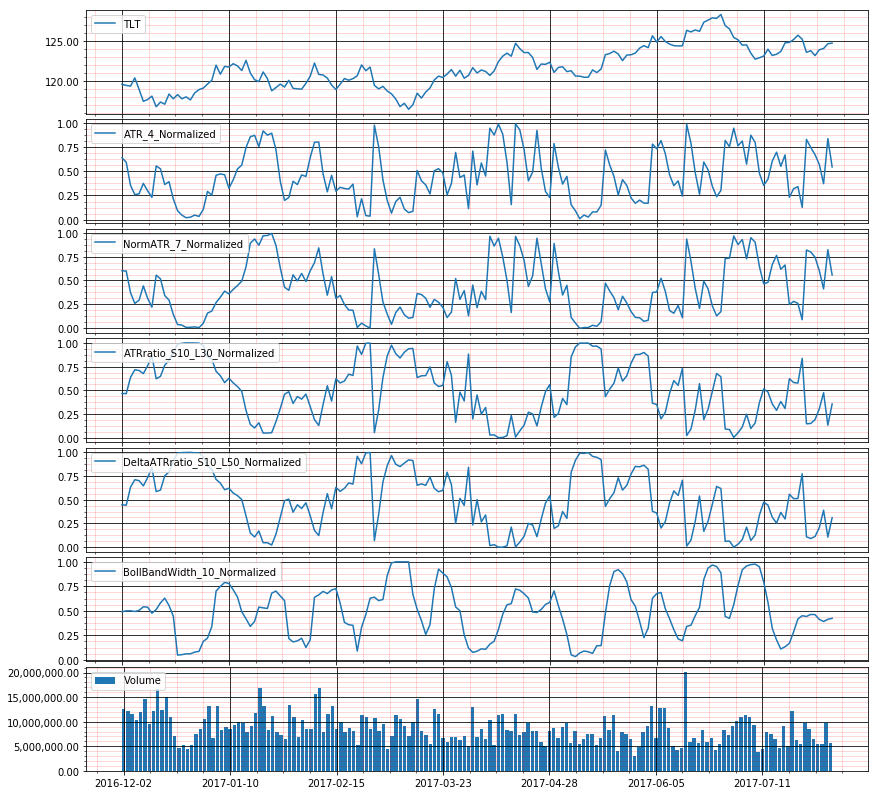

In [9]:
plot_dict = {}
plot_dict['Issue'] = issue
plot_vars = [k for k,v in feature_dict.items() if v == 'Keep']
plot_dict['Plot_Vars'] = plot_vars
plot_dict['Volume'] = 'Yes'
plotIt.price_Ind_Vol_Plot(plot_dict, mmData)

### Select features to drop including OHL, gainAhead, symbol, Date, Close

In [10]:
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Symbol', 'Date', 'Close', 'beLong', 'Volume']
for x in to_drop:
    col_vals.append(x)
mmData = dSet.drop_columns(mmData, col_vals)

In [11]:
print(mmData.head())

            ATR_4_Normalized  NormATR_7_Normalized  \
2016-12-02          0.638928              0.601824   
2016-12-05          0.591467              0.598566   
2016-12-06          0.353341              0.373531   
2016-12-07          0.258895              0.260559   
2016-12-08          0.266894              0.294102   

            ATRratio_S10_L30_Normalized  DeltaATRratio_S10_L50_Normalized  \
2016-12-02                     0.466583                          0.445930   
2016-12-05                     0.465017                          0.441709   
2016-12-06                     0.636303                          0.630309   
2016-12-07                     0.716332                          0.709276   
2016-12-08                     0.709359                          0.700040   

                  BBUB     BBMB        BBLB  BollBandWidth_10_Normalized  
2016-12-02  122.608958  120.707  118.805042                     0.491235  
2016-12-05  122.604966  120.569  118.533034                   

### Plot correlation matrix
Improve this to identify and drop features with corr value higher than 0.3
Look at other methods to identify features and their contribution

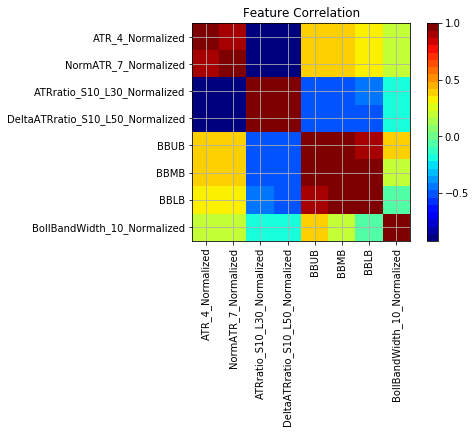

In [12]:
plotIt.correlation_matrix(mmData)

#### Examine and drop features with corr value > 0.85

In [13]:
# Create correlation matrix
corr_matrix = mmData.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
print(upper)

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("\n=====To Drop=====\n" + str(to_drop))

                                  ATR_4_Normalized  NormATR_7_Normalized  \
ATR_4_Normalized                               NaN              0.923734   
NormATR_7_Normalized                           NaN                   NaN   
ATRratio_S10_L30_Normalized                    NaN                   NaN   
DeltaATRratio_S10_L50_Normalized               NaN                   NaN   
BBUB                                           NaN                   NaN   
BBMB                                           NaN                   NaN   
BBLB                                           NaN                   NaN   
BollBandWidth_10_Normalized                    NaN                   NaN   

                                  ATRratio_S10_L30_Normalized  \
ATR_4_Normalized                                    -0.917980   
NormATR_7_Normalized                                -0.910684   
ATRratio_S10_L30_Normalized                               NaN   
DeltaATRratio_S10_L50_Normalized                       